## The Battle of Neighborhoods: Coursera Capstone Project week 2

## Food taste in Music City Nashville, Tennessee

#### Import Libraries 

In [6]:
import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


### Data import from .xlsx files

import Borough and postal code data for Nashville, TN. Prescrape from Wikipedia, Nashville, Tennessee and stored in PostalCode_Nashville.xlsx file.

In [7]:
df_Nashville = pd.read_excel (r'C:\Users\Dr Anuj Tripathi\Desktop\PostalCode_Nashville_Tn.xlsx')## from nashville postal site
print (df_Nashville)

    PostalCode            Borough                              Neighborhood
0        37013          Nashville                                   Antioch
1        37205        Belle Meade                    Belle Meade Plantation
2        37221          Nashville                                  Bellevue
3        37207         Williamson                                 Brentwood
4        37206          Nashville                            East Nashville
5        37064         Williamson                                  Franklin
6        37214           Donelson                         Gaylord Opryland 
7        37130       Murfreesboro            Geographic Center of Tennessee
8        37208          Nashville                                Germantown
9        37072             Sumner                            Goodlettsville
10       37215          Nashville                               Green Hills
11       37075             Sumner                            Hendersonville
12       372

### Data cleaning

In [8]:
not_assigned_boroughs = df_Nashville.index[df_Nashville['Borough'] == 'Not assigned']
not_assigned_neighborhoods = df_Nashville.index[df_Nashville['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(df_Nashville.shape),'\n')
print('There are:')
print('  {} PostalCodes'.format(df_Nashville['PostalCode'].unique().shape[0]))
print('  {} Boroughs'.format(df_Nashville['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(df_Nashville['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count

The DataFrame shape is (27, 3) 

There are:
  26 PostalCodes
  7 Boroughs
  26 Neighborhoods


In [9]:
group = df_Nashville.groupby('PostalCode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['PostalCode', 'Borough', 'Neighborhood']

grouped_df.head()

,PostalCode,Borough,Neighborhood
0,37013,Nashville,Antioch
1,37064,Williamson,Franklin
2,37072,Sumner,Goodlettsville
3,37075,Sumner,Hendersonville
4,37076,Nashville,The Hermitage


In [10]:
print('The DataFrame shape is', grouped_df.shape)

The DataFrame shape is (26, 3)


Import data related to Latitude and Longitude data according to Zip codes.

In [11]:
# US Zip Code Latitude and Longitude data excel(https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/)

coordinates_df = pd.read_excel (r'C:\Users\Dr Anuj Tripathi\Desktop\us-zip-code-latitude-and-longitude.xlsx')

coordinates_df.head()

,PostalCode,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.39398,-6,1,"34.398483, -94.39398"
1,72044,Edgemont,AR,35.624351,-92.16056,-6,1,"35.624351, -92.16056"
2,56171,Sherburn,MN,43.660847,-94.74357,-6,1,"43.660847, -94.74357"
3,49430,Lamont,MI,43.010337,-85.89754,-5,1,"43.010337, -85.89754"
4,52585,Richland,IA,41.194129,-91.98027,-6,1,"41.194129, -91.98027"


In [12]:
coordinates_df = coordinates_df.drop(["Timezone","geopoint","State","Daylight savings time flag","City"],axis=1)
coordinates_df.head()

,PostalCode,Latitude,Longitude
0,71937,34.398483,-94.39398
1,72044,35.624351,-92.16056
2,56171,43.660847,-94.74357
3,49430,43.010337,-85.89754
4,52585,41.194129,-91.98027


In [13]:
df_Nashville_Tn = pd.merge(grouped_df, coordinates_df, how='left', left_on = 'PostalCode', right_on = 'PostalCode')
# remove the "PostalCode" column
df_Nashville_Tn.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,37013,Nashville,Antioch,36.055115,-86.64782
1,37064,Williamson,Franklin,35.893823,-86.89919
2,37072,Sumner,Goodlettsville,36.354650,-86.71879
3,37075,Sumner,Hendersonville,36.311047,-86.61173
4,37076,Nashville,The Hermitage,36.180507,-86.60111


#### Search geograpical coordinate of Nashville Tennessee with help of geolocator(Nominatim) and geolocator.geocode

In [14]:
address = "Nashville Tennessee, ON"

geolocator = Nominatim(user_agent="Nashville Tennessee_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Nashville Tennessee are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Nashville Tennessee are 36.17405235, -86.76364612210365.


###  Create map of Nashville with help of folium

In [15]:
# create map of Nashville using latitude and longitude values
map_Nashville_Tennessee = folium.Map(location=[latitude, longitude], zoom_start=10)
map_Nashville_Tennessee

### Boroughs superimposed on map of Nashville, TN using the latitude and longitude values 

In [16]:
for lat, lng, borough, neighborhood in zip(
        df_Nashville_Tn['Latitude'], 
        df_Nashville_Tn['Longitude'], 
        df_Nashville_Tn['Borough'], 
        df_Nashville_Tn['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Nashville_Tennessee)  

map_Nashville_Tennessee

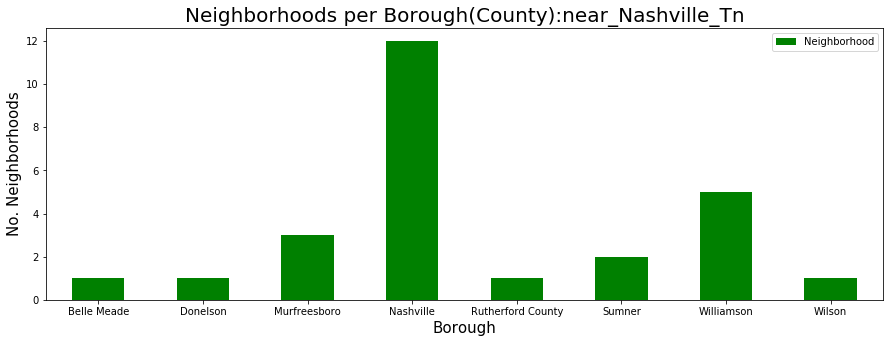

In [18]:
import matplotlib.pyplot as plt
clr = "green"
df_Nashville_Tn.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(15,5), color=clr)
plt.title('Neighborhoods per Borough(County):near_Nashville_Tn', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

## Analysis of Top 10 pizza place in neighbor city of Nashville_TN using FourSquare API 

In [20]:

CLIENT_ID = 'HzzzzzzzzDJJJJxxxxxxxxxKDJDvvvvvvvvvvvvvvvDX' # your Foursquare ID
CLIENT_SECRET = 'TbsnjSSSCMKMKMMVKKKCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC14' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

Your credentails:
CLIENT_ID: H0PQ5QQTUYOLHG4VY4VXRX5UI51MN0CQSZELBISKW2ASNADX


In [21]:
LIMIT = 10 # Maximum is 100
cities = ["Nashville, TN", 'Belle Meade, TN', 'Brentwood, TN', 'Franklin, TN', 'Goodlettsville, TN', 'Mount Juliet, TN', 'Murfreesboro, TN', 'Spring Hill, TN', 'Smyrna, TN']
results = {}
for city in cities:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        city,
        LIMIT,
        "4bf58dd8d48988d1ca941735") # PIZZA PLACE CATEGORY ID
    results[city] = requests.get(url).json()

In [22]:
df_venues={}
for city in cities:
    venues = json_normalize(results[city]['response']['groups'][0]['items'])
    df_venues[city] = venues[['venue.name', 'venue.location.address', 'venue.location.lat', 'venue.location.lng']]
    df_venues[city].columns = ['Name', 'Address', 'Lat', 'Lng']

In [23]:
maps = {}
for city in cities:
    city_lat = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lat'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lat']])
    city_lng = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lng'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lng']])
    maps[city] = folium.Map(location=[city_lat, city_lng], zoom_start=11)

    # add markers to map
    for lat, lng, label in zip(df_venues[city]['Lat'], df_venues[city]['Lng'], df_venues[city]['Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(maps[city])  
    print(f"Total number of pizza places in {city} = ", results[city]['response']['totalResults'])
    print("Showing Top 10")

Total number of pizza places in Nashville, TN =  123
Showing Top 10
Total number of pizza places in Belle Meade, TN =  18
Showing Top 10
Total number of pizza places in Brentwood, TN =  13
Showing Top 10
Total number of pizza places in Franklin, TN =  46
Showing Top 10
Total number of pizza places in Goodlettsville, TN =  34
Showing Top 10
Total number of pizza places in Mount Juliet, TN =  17
Showing Top 10
Total number of pizza places in Murfreesboro, TN =  64
Showing Top 10
Total number of pizza places in Spring Hill, TN =  13
Showing Top 10
Total number of pizza places in Smyrna, TN =  14
Showing Top 10


#### Locate Top 10 Pizza Place in city Map of Nashville, TN

In [25]:
maps[cities[0]]

#### Locate Top 10 Pizza Place in city Map of Belle Meade, TN

In [26]:
maps[cities[1]]

#### Locate Top 10 Pizza Place in city Map of Brentwood, TN

In [27]:
maps[cities[2]]

#### Locate Top 10 Pizza Place in city Map of Franklin, TN 

In [28]:
maps[cities[3]]

#### Locate Top 10 Pizza Place in city Map of Goodlettsville, TN

In [29]:
maps[cities[4]]

#### Locate Top 10 Pizza Place in city Map of Mount Juliet, TN

In [30]:
maps[cities[5]]

#### Locate Top 10 Pizza Place in city Map of Murfreesboro, TN

In [31]:
maps[cities[6]]

#### Locate Top 10 Pizza Place in city Map of Spring Hill, TN

In [32]:
maps[cities[7]]

#### Locate Top 10 Pizza Place in city Map of Smyrna, TN

In [33]:
maps[cities[8]]

#### mean distance of top 10 Pizza Place from city mean coordinate

However, Let's have a concrete measure of this density.

For this I will use some basic statistics. I will get the mean location of the pizza places which should be near to most of them if they are really dense or far if not.

Next I will take the average of the distance of the venues to the mean coordinates.

In [34]:
maps = {}
for city in cities:
    city_lat = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lat'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lat']])
    city_lng = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lng'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lng']])
    maps[city] = folium.Map(location=[city_lat, city_lng], zoom_start=11)
    venues_mean_coor = [df_venues[city]['Lat'].mean(), df_venues[city]['Lng'].mean()] 
    # add markers to map
    for lat, lng, label in zip(df_venues[city]['Lat'], df_venues[city]['Lng'], df_venues[city]['Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(maps[city])
        folium.PolyLine([venues_mean_coor, [lat, lng]], color="green", weight=1.5, opacity=0.5).add_to(maps[city])
    
    label = folium.Popup("Mean Co-ordinate", parse_html=True)
    folium.CircleMarker(
        venues_mean_coor,
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(maps[city])

    print(city)
    print("Mean Distance from Mean coordinates")
    print(np.mean(np.apply_along_axis(lambda x: np.linalg.norm(x - venues_mean_coor),1,df_venues[city][['Lat','Lng']].values)))

Nashville, TN
Mean Distance from Mean coordinates
0.029552093139911924
Belle Meade, TN
Mean Distance from Mean coordinates
0.0320715042526388
Brentwood, TN
Mean Distance from Mean coordinates
0.03955409706907507
Franklin, TN
Mean Distance from Mean coordinates
0.033816588198426784
Goodlettsville, TN
Mean Distance from Mean coordinates
0.0405341941817435
Mount Juliet, TN
Mean Distance from Mean coordinates
0.02084485389917041
Murfreesboro, TN
Mean Distance from Mean coordinates
0.038090735959114205
Spring Hill, TN
Mean Distance from Mean coordinates
0.021085356499334216
Smyrna, TN
Mean Distance from Mean coordinates
0.023821369467637125


## Explore venues of Music City Nashville using FourSquare API

In [35]:
#Getting the latitude and longitude values of the above neighborhood
lat = latitude # neighborhood latitude value
lng = longitude # neighborhood longitude value

LIMIT = 200 # limit of number of venues returned by Foursquare API

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
Nashville_venues = getNearbyVenues(names=df_Nashville_Tn['Neighborhood'],
                                   latitudes=df_Nashville_Tn['Latitude'],
                                   longitudes=df_Nashville_Tn['Longitude']
                                  )

Antioch
Franklin
Goodlettsville
Hendersonville
The Hermitage
Madison
Mount Juliet
Stones River National Battlefield
Geographic Center of Tennessee
Middle Tennessee State University
Nolensville
Lakewood
Smyrna
Spring Hill
Thompson's Station
Whites Creek
The Gulch
Belle Meade Plantation
East Nashville
Brentwood
Germantown, North Nashville
West Nashville
Hillsboro Village/ Venderbilt University
Gaylord Opryland 
Green Hills
Bellevue


In [38]:
print(Nashville_venues.shape)
Nashville_venues.head()

(709, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Antioch,36.055115,-86.64782,Ford Ice Center,36.053014,-86.656621,Skating Rink
1,Antioch,36.055115,-86.64782,Zaxby's Chicken Fingers & Buffalo Wings,36.049856,-86.651551,Fried Chicken Joint
2,Antioch,36.055115,-86.64782,Waffle House,36.051700,-86.645400,Breakfast Spot
3,Antioch,36.055115,-86.64782,Thorntons,36.051673,-86.644662,Convenience Store
4,Antioch,36.055115,-86.64782,AMC Theater,36.050990,-86.651680,Movie Theater


In [39]:
# Number of venues for each nrighborhood
Nashville_venues.groupby('Neighborhood')
print('There are {} uniques categories.'.format(len(Nashville_venues['Venue Category'].unique())))

There are 185 uniques categories.


### Extracting only restaurants from venue category list and creating a dataframe "Nashville_restaurants"

In [41]:
Nashville_restaurants = Nashville_venues[Nashville_venues['Venue Category'].str.contains("Restaurant")]

In [42]:

print('There are {} unique categories or cusines available in Nashville.'.format(len(Nashville_restaurants['Venue Category'].unique())))

There are 24 unique categories or cusines available in Nashville.


In [43]:
# one hot encoding
Nashville_onehot = pd.get_dummies(Nashville_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Nashville_onehot['Neighborhood'] = Nashville_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Nashville_onehot.columns[-1]] + list(Nashville_onehot.columns[:-1])
Nashville_onehot = Nashville_onehot[fixed_columns]

Nashville_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Portuguese Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
7,Antioch,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Antioch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,Antioch,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
25,Antioch,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,Antioch,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
print('There are {} restaurants in Nashville with {} different style of cuisines.'.format(Nashville_onehot.shape[0],(Nashville_onehot.shape[1]-1)))

There are 122 restaurants in Nashville with 24 different style of cuisines.


### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category/restaurants

In [45]:
Nashville_grouped = Nashville_onehot.groupby('Neighborhood').mean().reset_index()
Nashville_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Portuguese Restaurant,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Antioch,0.142857,0.142857,0.0000,0.000000,0.428571,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.142857,0.000000,0.000000,0.000000,0.0000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Brentwood,0.000000,0.000000,0.0000,0.000000,1.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,East Nashville,0.312500,0.062500,0.0625,0.000000,0.000000,0.0625,0.0625,0.000000,0.000000,0.062500,0.0625,0.000000,0.000000,0.062500,0.000000,0.0625,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.062500,0.000000
3,Gaylord Opryland,0.000000,0.000000,0.0000,0.000000,0.200000,0.0000,0.2000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.200000,0.000000,0.0000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Geographic Center of Tennessee,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,1.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Germantown, North Nashville",0.166667,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.166667,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000
6,Green Hills,0.250000,0.250000,0.0000,0.000000,0.250000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.250000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Hendersonville,0.000000,0.000000,0.0000,0.000000,0.250000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.250000,0.250000,0.0000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Hillsboro Village/ Venderbilt University,0.400000,0.100000,0.0000,0.000000,0.100000,0.1000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.100000,0.100000,0.100000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Lakewood,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [46]:
Nashville_grouped.shape

(17, 25)

### Top 3 restaurants for each Neighborhood based on cuisine

In [47]:
num_top_rest = 3

for hood in Nashville_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Nashville_grouped[Nashville_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_rest))
    print('\n')

----Antioch----
                  venue  freq
0  Fast Food Restaurant  0.43
1   American Restaurant  0.14
2            Restaurant  0.14


----Brentwood----
                  venue  freq
0  Fast Food Restaurant   1.0
1   American Restaurant   0.0
2    Mexican Restaurant   0.0


----East Nashville----
                  venue  freq
0   American Restaurant  0.31
1      Sushi Restaurant  0.12
2  Caribbean Restaurant  0.06


----Gaylord Opryland ----
                  venue  freq
0    Seafood Restaurant   0.4
1    Mexican Restaurant   0.2
2  Fast Food Restaurant   0.2


----Geographic Center of Tennessee----
                 venue  freq
0   Mexican Restaurant   1.0
1  American Restaurant   0.0
2     Asian Restaurant   0.0


----Germantown, North Nashville----
                             venue  freq
0              American Restaurant  0.17
1    Vegetarian / Vegan Restaurant  0.17
2  Southern / Soul Food Restaurant  0.17


----Green Hills----
                  venue  freq
0   American Restaur

### Creating a new dataframe with the above results for each neighborhood

In [48]:
# A function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
#Creating a new dataframe and displaying the top 10 restaurants based on occurance and cuisine for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Nashville_grouped['Neighborhood']


for ind in np.arange(Nashville_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Nashville_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Antioch,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
1,Brentwood,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant
2,East Nashville,American Restaurant,Sushi Restaurant,Asian Restaurant,Caribbean Restaurant,French Restaurant,Portuguese Restaurant,Greek Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant
3,Gaylord Opryland,Seafood Restaurant,Fast Food Restaurant,Greek Restaurant,Mexican Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,French Restaurant
4,Geographic Center of Tennessee,Mexican Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant


## Machine Learning Algorithm: Clustering and Segmentation of Neighborhoods with Similar Venues

### Finding the best k

In [54]:
# set number of clusters
kclusters = 7

Nashville_grouped_clustering = Nashville_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Nashville_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 1, 1, 4, 1, 1, 1, 1, 3, 6, 1, 5, 1, 1, 0, 1])

In [55]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Nashville_merged = Nashville_restaurants

# merge Nashville_grouped with Nashville_data to add latitude/longitude for each neighborhood
Nashville_merged = Nashville_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Nashville_merged.fillna(0)
Nashville_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Antioch,36.055115,-86.64782,Kirin Sushi,36.051159,-86.649784,Asian Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
8,Antioch,36.055115,-86.64782,Chuck E. Cheese,36.047788,-86.651820,Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
9,Antioch,36.055115,-86.64782,Joselito's,36.050453,-86.651222,Latin American Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
25,Antioch,36.055115,-86.64782,O'Charley's,36.049597,-86.652545,American Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
28,Antioch,36.055115,-86.64782,Arby's,36.048561,-86.651070,Fast Food Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant


## Finally, let's visualize the resulting clusters

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Nashville_merged['Neighborhood Latitude'], Nashville_merged['Neighborhood Longitude'], Nashville_merged['Neighborhood'], Nashville_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine each Clusters

#### Cluster 1

In [58]:
Nashville_merged.loc[Nashville_merged['Cluster Labels'] == 0, Nashville_merged.columns[[1] + list(range(5, Nashville_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
257,35.79867,-86.910504,New American Restaurant,0,Restaurant,New American Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant
259,35.79867,-86.905258,Restaurant,0,Restaurant,New American Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant


#### Cluster 2

In [59]:
Nashville_merged.loc[Nashville_merged['Cluster Labels'] == 1, Nashville_merged.columns[[1] + list(range(5, Nashville_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,36.055115,-86.649784,Asian Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
8,36.055115,-86.651820,Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
9,36.055115,-86.651222,Latin American Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
25,36.055115,-86.652545,American Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
28,36.055115,-86.651070,Fast Food Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
30,36.055115,-86.653209,Fast Food Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
36,36.055115,-86.652858,Fast Food Restaurant,1,Fast Food Restaurant,Latin American Restaurant,Restaurant,Asian Restaurant,American Restaurant,Southern / Soul Food Restaurant,Indonesian Restaurant,Thai Restaurant,Caribbean Restaurant,Chinese Restaurant
56,36.311047,-86.607730,Fast Food Restaurant,1,Southern / Soul Food Restaurant,Fast Food Restaurant,New American Restaurant,Mexican Restaurant,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,French Restaurant
58,36.311047,-86.608565,Southern / Soul Food Restaurant,1,Southern / Soul Food Restaurant,Fast Food Restaurant,New American Restaurant,Mexican Restaurant,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,French Restaurant
63,36.311047,-86.604879,Mexican Restaurant,1,Southern / Soul Food Restaurant,Fast Food Restaurant,New American Restaurant,Mexican Restaurant,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,French Restaurant


#### Cluster 3

In [60]:
Nashville_merged.loc[Nashville_merged['Cluster Labels'] == 2, Nashville_merged.columns[[1] + list(range(5, Nashville_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
451,36.215535,-86.768097,Fast Food Restaurant,2,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant
461,36.215535,-86.777326,Fast Food Restaurant,2,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant


#### Cluster 4

In [61]:
Nashville_merged.loc[Nashville_merged['Cluster Labels'] == 3, Nashville_merged.columns[[1] + list(range(5, Nashville_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
235,36.243698,-86.633815,Thai Restaurant,3,Thai Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant


#### Cluster 5

In [62]:
Nashville_merged.loc[Nashville_merged['Cluster Labels'] == 4, Nashville_merged.columns[[1] + list(range(5, Nashville_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
157,35.860152,-86.371692,Mexican Restaurant,4,Mexican Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant


#### Cluster 6

In [63]:
Nashville_merged.loc[Nashville_merged['Cluster Labels'] == 5, Nashville_merged.columns[[1] + list(range(5, Nashville_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
248,35.968513,-86.519688,American Restaurant,5,American Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant


#### Cluster7

In [64]:
Nashville_merged.loc[Nashville_merged['Cluster Labels'] == 6, Nashville_merged.columns[[1] + list(range(5, Nashville_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
127,36.264069,-86.712213,Chinese Restaurant,6,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Caribbean Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant
134,36.264069,-86.711423,Seafood Restaurant,6,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Japanese Restaurant,Asian Restaurant,Caribbean Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant


### Summery
For food search and taste search nashville is best place in Music city Nashville, TN.
For open New Pizza Place or Restaurant Goodlettsville, TN, is better place due to scattering view of Pizza Place or Restaurant.

Thanks